In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import json
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Обучал в google colab. Поэтому все пути оттуда.

# Пути к весам модели и тестовым изображениям не участвовавшим в обучении.

path_to_modelweight = "drive/MyDrive/Colab Notebooks/comexp/model/model_09062022_15.pth"
path_to_test = 'drive/MyDrive/Colab Notebooks/comexp/test/'

In [ ]:
_classes = ['blackbox']

class_to_int = {'blackbox': 1}
int_to_class = {1: 'blackbox'}


In [ ]:
class BBDetectionDataset(Dataset):
    
    def __init__(self, path, mode = 'test', transforms = None):
        
        super().__init__()

        self.image_name = path
        self.transforms = transforms
        self.mode = mode
        
        
    def __getitem__(self, index: int):
        
        image = cv2.imread(self.image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
        image /= 255.0
        
        if self.mode == 'train':
            pass

        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            
            return image, self.image_name
    
    def __len__(self):
        #return len(self.image_name)
        return 1

In [ ]:
def get_transform():
    return T.Compose([T.ToTensor()])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Очистка памяти
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
#Faster - RCNN модель обученная на COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)+1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
# Загрузим получившуюся модель и посмотрим, как она работает.

checkpoint = torch.load(path_to_modelweight, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Функция для запуска модели и её проверки на разных изображениях.
# Функция получает путь к изображению, модель ищет на этом изображении черные рамки
# если находит, рисуем прямоугольник зеленого цвета.

def BB_Detector(path_to_image):
    
    test_dataset = BBDetectionDataset(path_to_image, mode = 'test', transforms = get_transform())

    test_data_loader = DataLoader(test_dataset,batch_size=1,shuffle=False,num_workers=1,drop_last=False,collate_fn=collate_fn)

    threshold = 0.6
    model.eval()

    image_open = cv2.imread(path_to_image, cv2.IMREAD_COLOR)
    image_open = cv2.cvtColor(image_open, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_open /= 255.0   

    for images, image_names in test_data_loader:
        images = list(image.to(device) for image in images)
        output = model(images)

        boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()
        labels = output[0]['labels'].data.cpu().numpy()
    
        boxes_th = boxes[scores >= threshold].astype(np.int32)
        scores_th = scores[scores >= threshold]
      
        labels_th = []
        for x in range(len(labels)):
            if scores[x] > threshold:
                labels_th.append(int_to_class[labels[x]])
    


        for y in range(len(boxes_th)):
            
            x1 = boxes_th[y][0]
            y1 = boxes_th[y][1]
            x2 = boxes_th[y][2]
            y2 = boxes_th[y][3]
            class_name = labels_th[y]

                        
            row = {"image_name" : image_names[0], "xmin" : x1, "xmax" : x2, "ymin" : y1, "ymax" : y2, "type" : class_name}
            #print(row)
               
            submission.append(row)

            if len(boxes_th)> 0:
                cv2.rectangle(image_open, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 3)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image_open, class_name, (int(x1),int(y1-15)), font, 2, (0,255,0), 2)


    v = image_open.tolist()
    return v



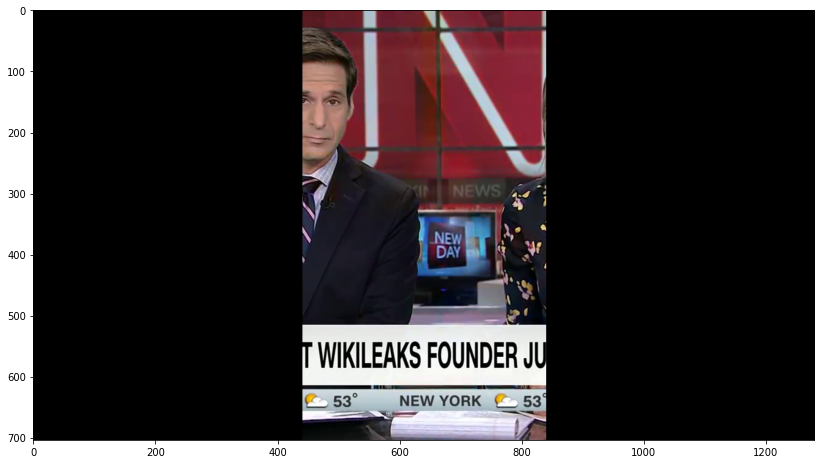

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


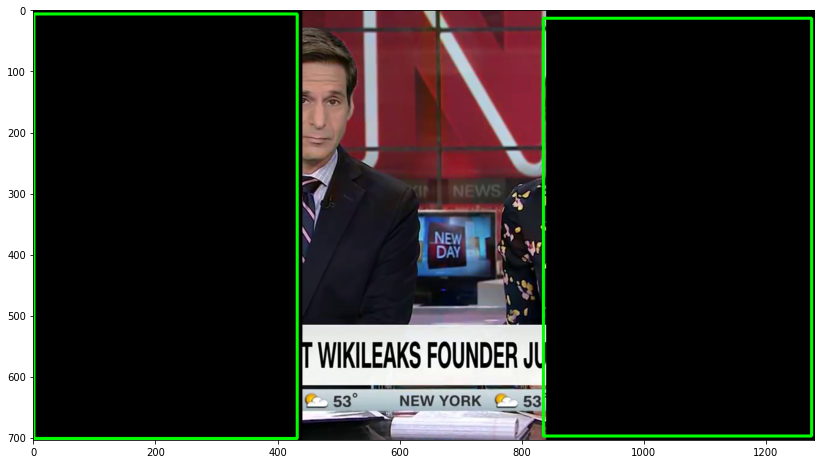

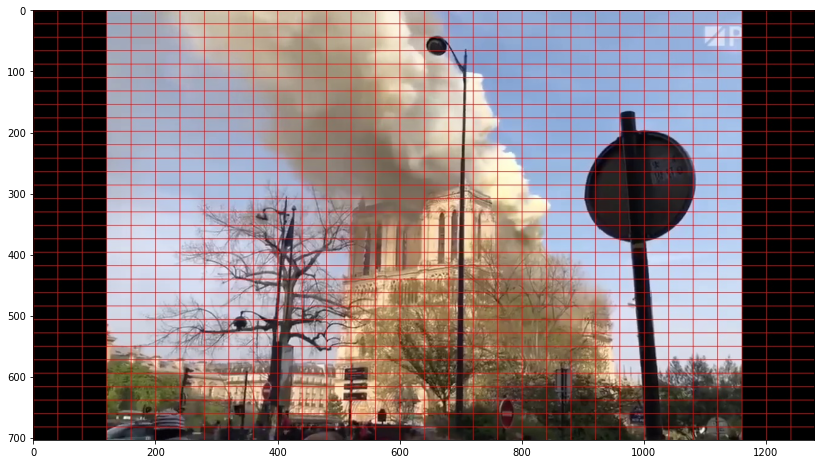

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


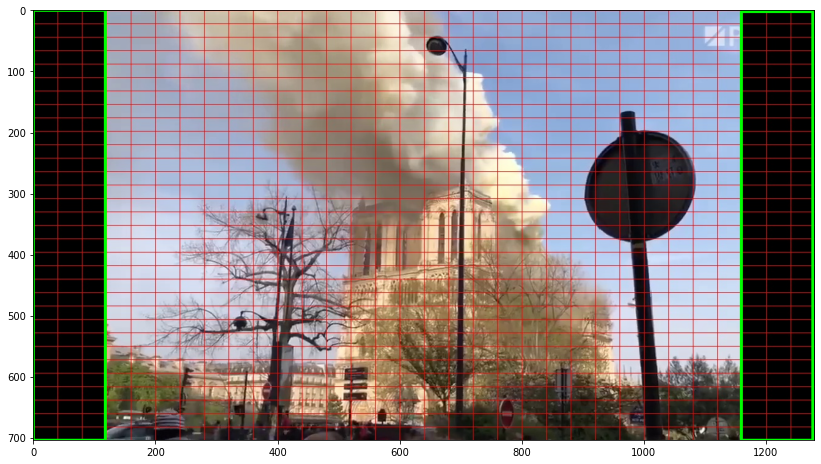

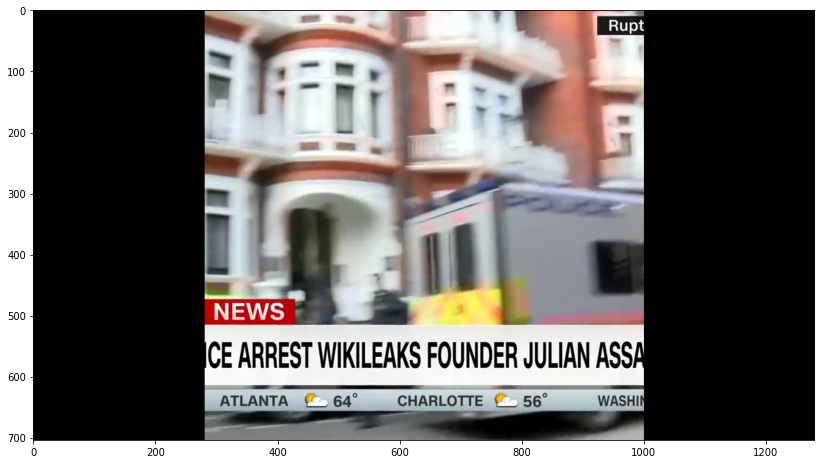

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


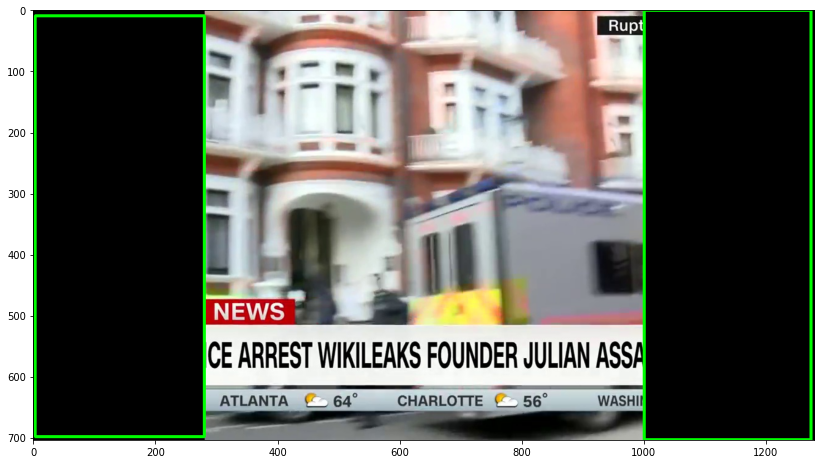

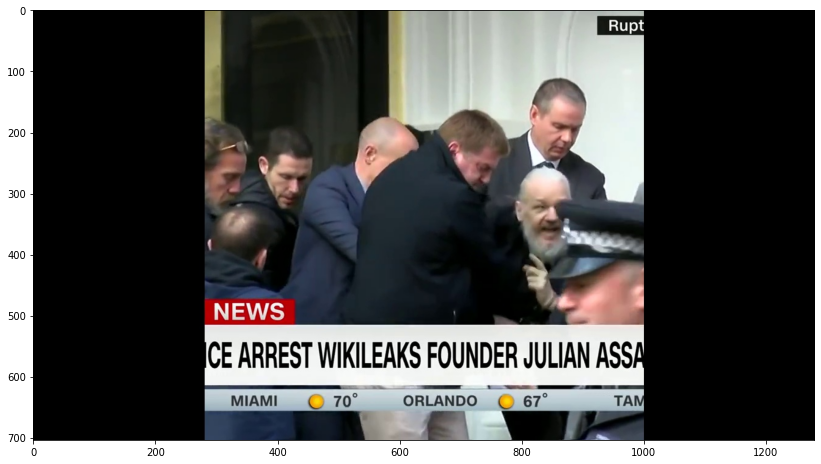

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


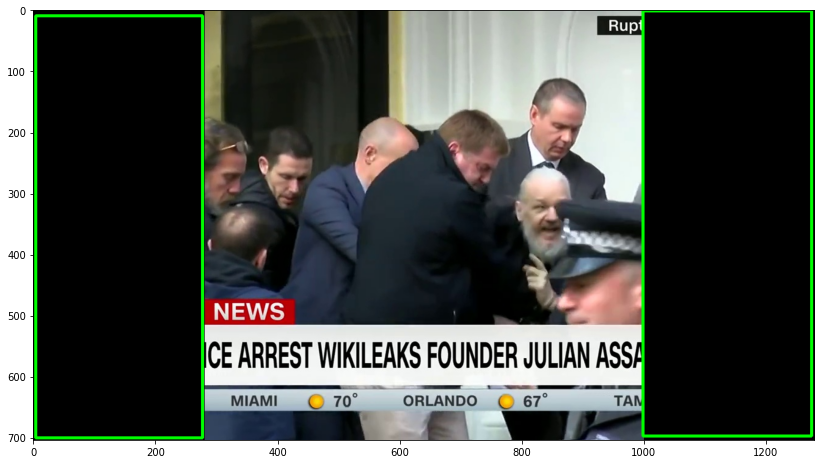

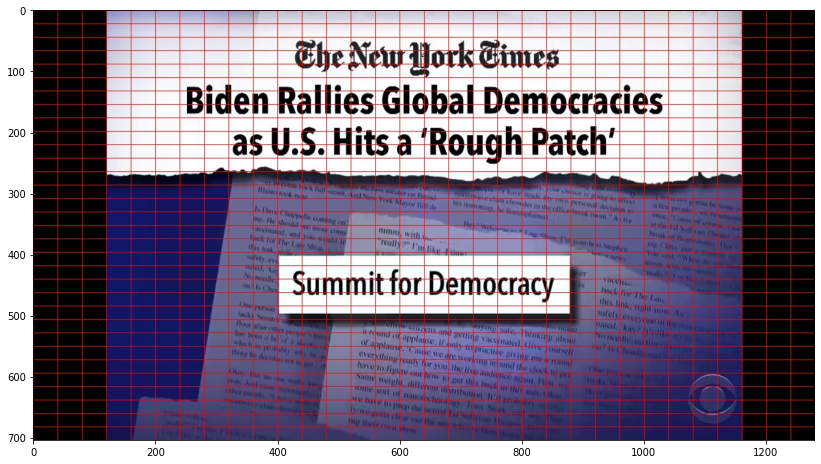

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


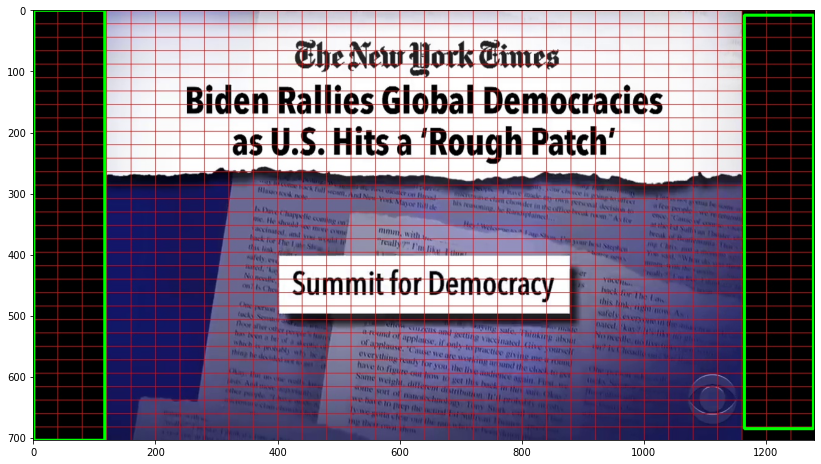

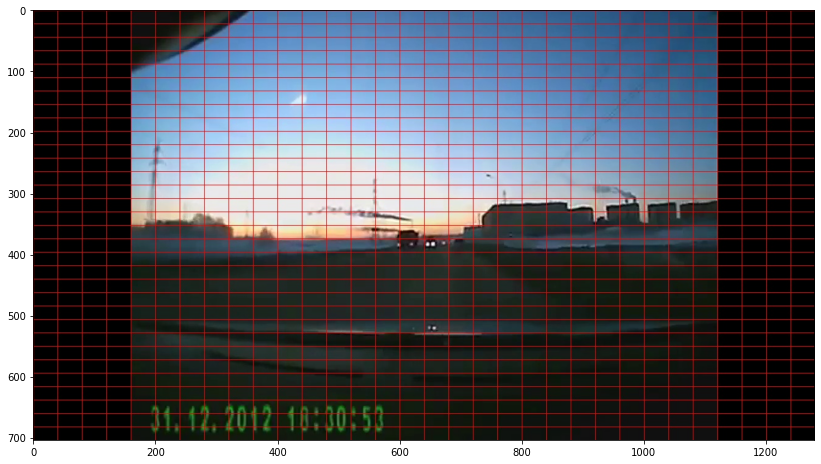

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


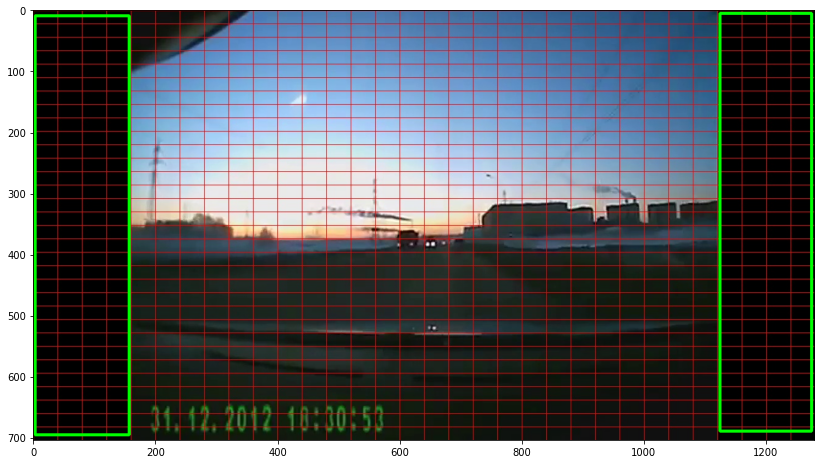

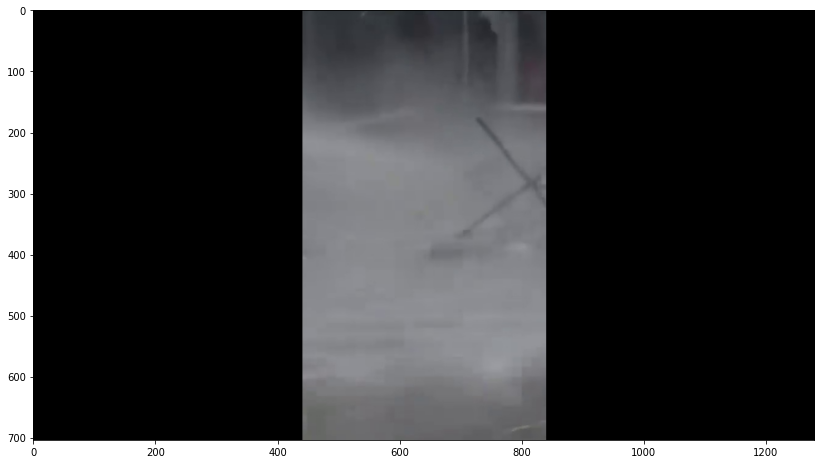

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


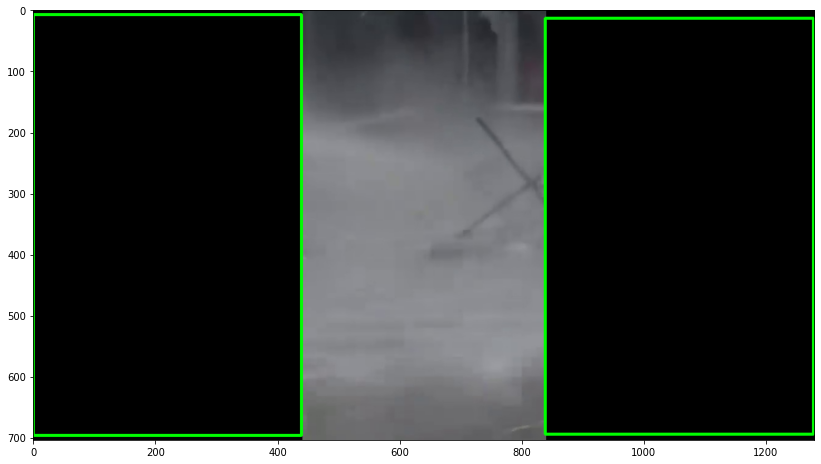

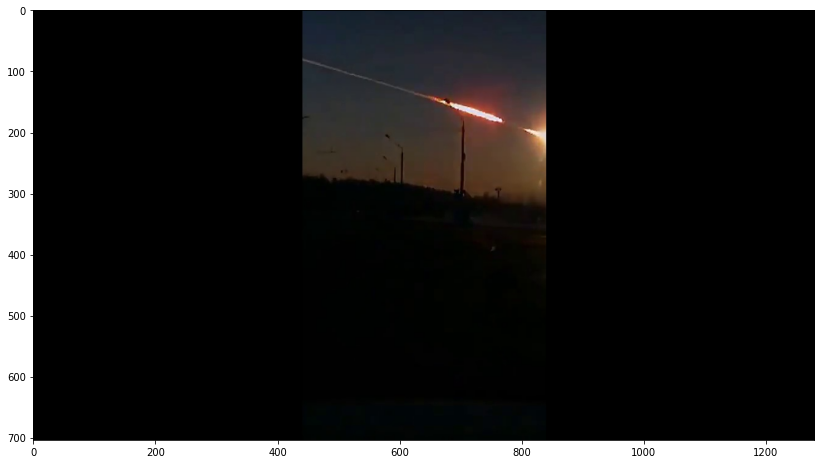

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


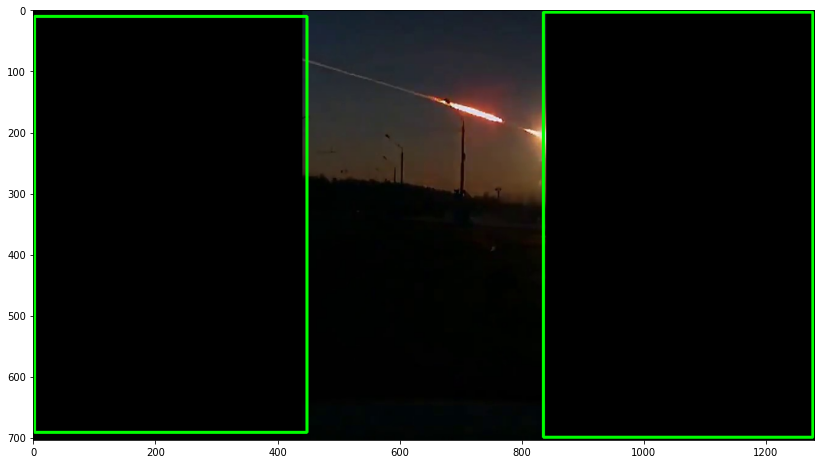

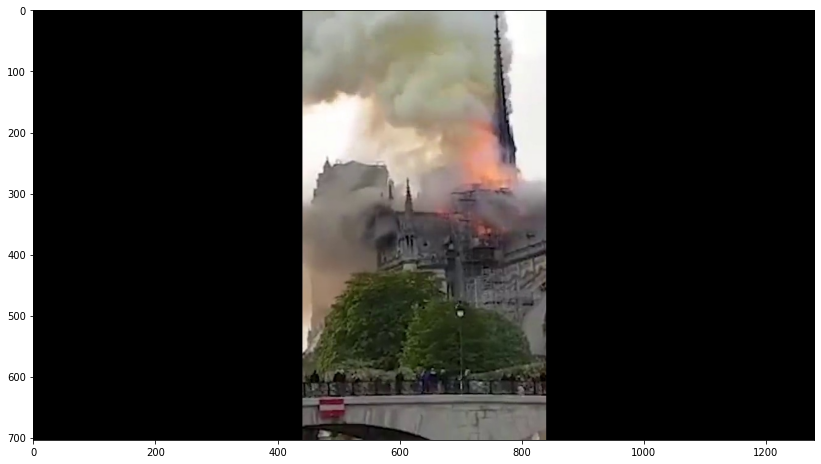

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


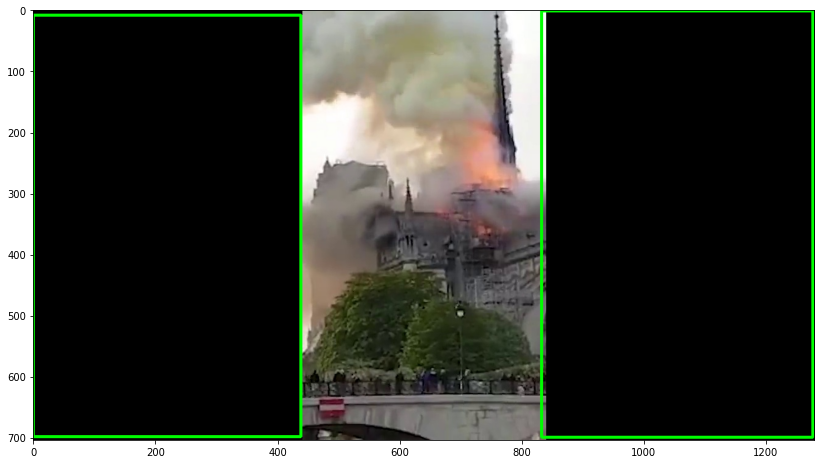

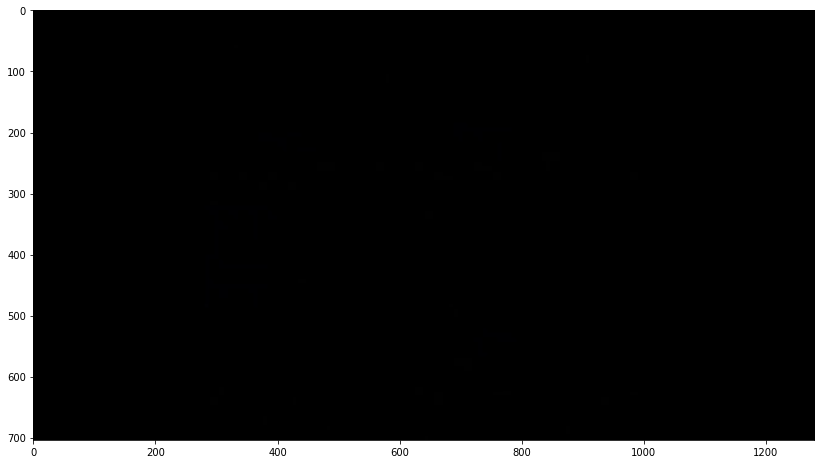

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


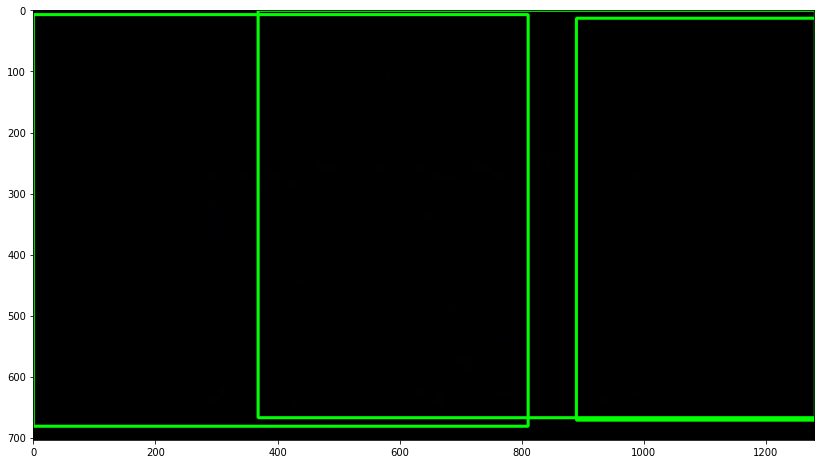

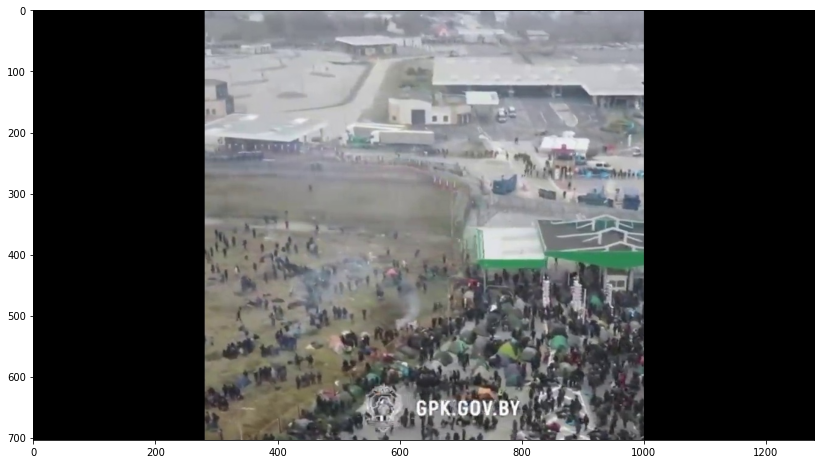

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


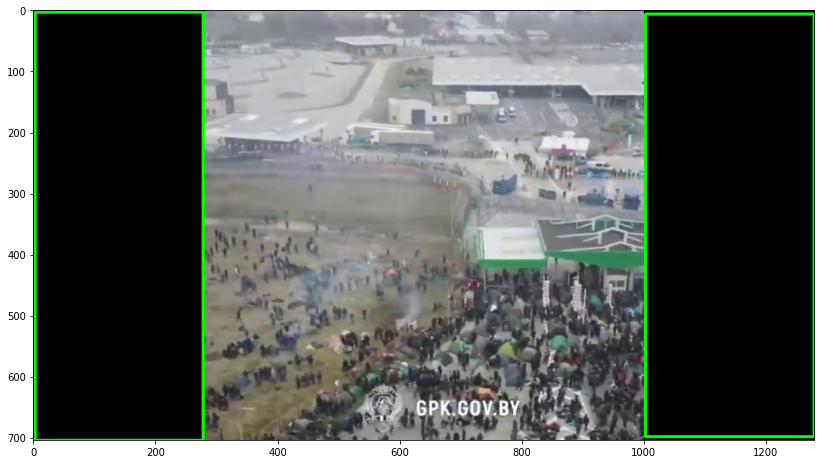

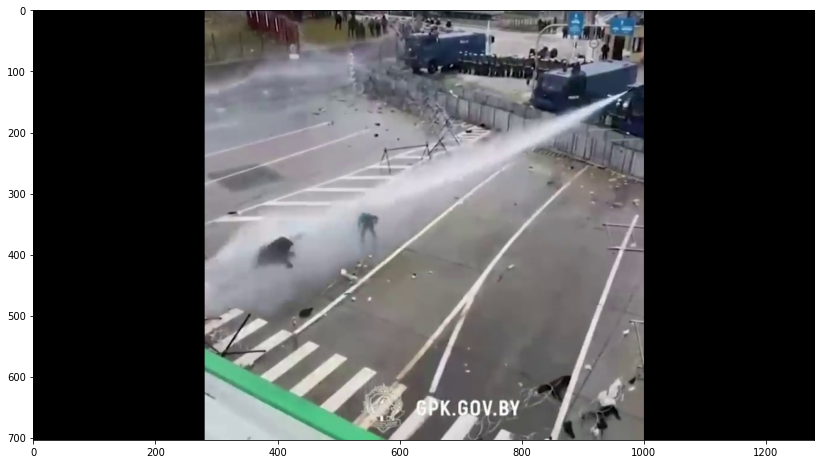

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


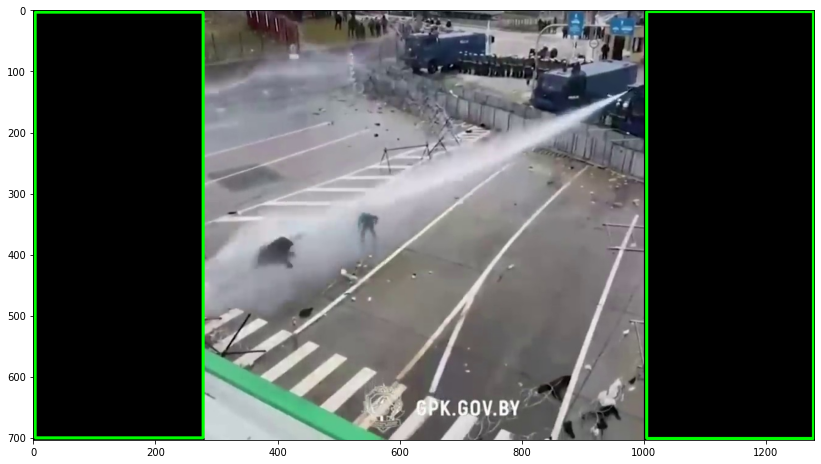

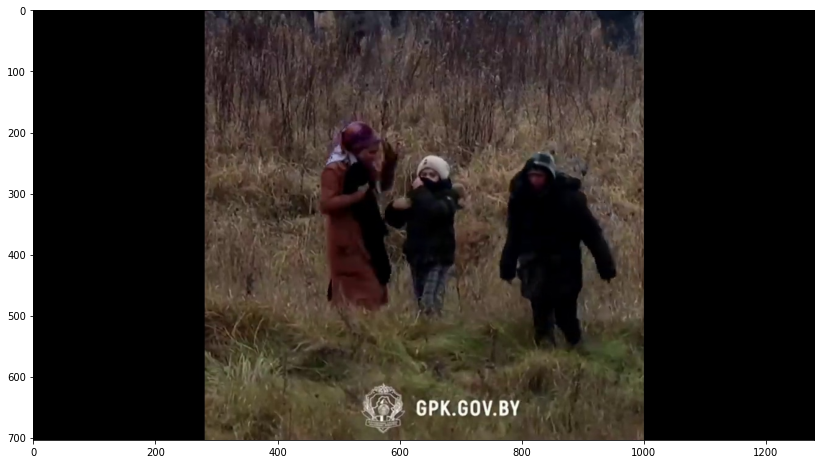

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


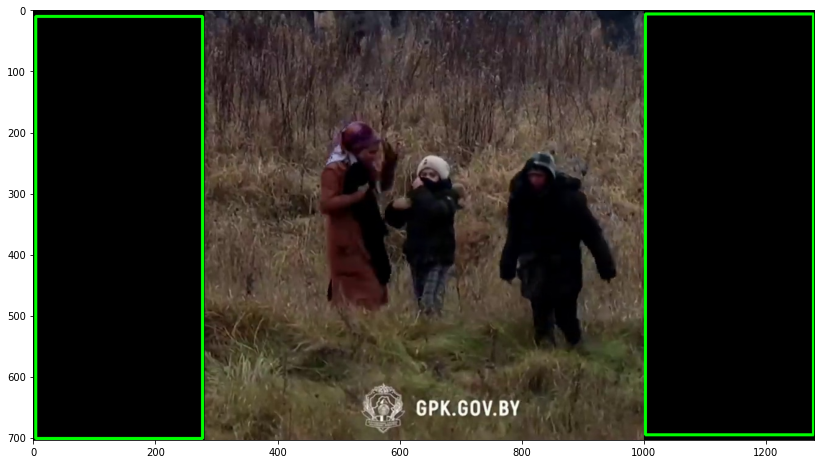

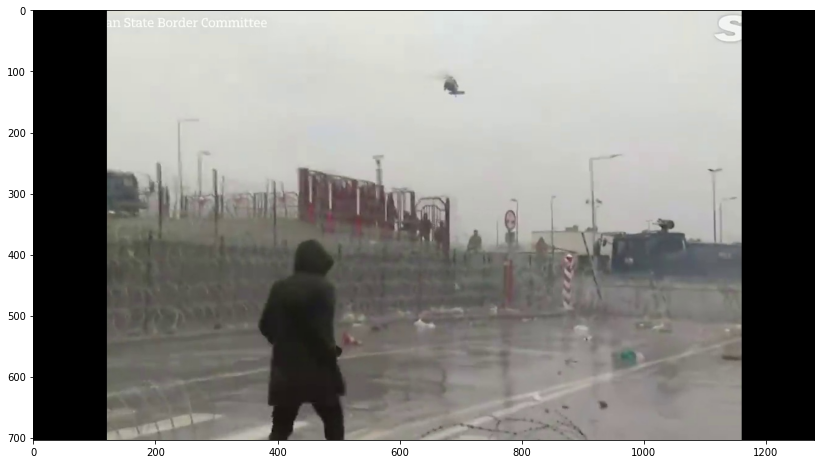

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


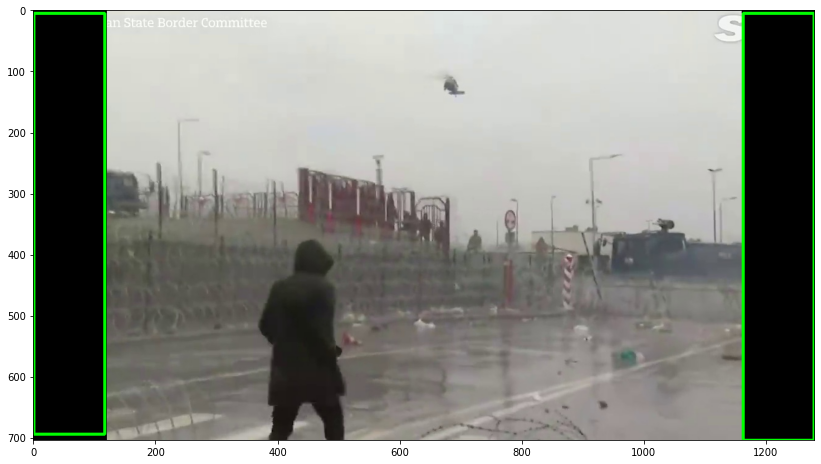

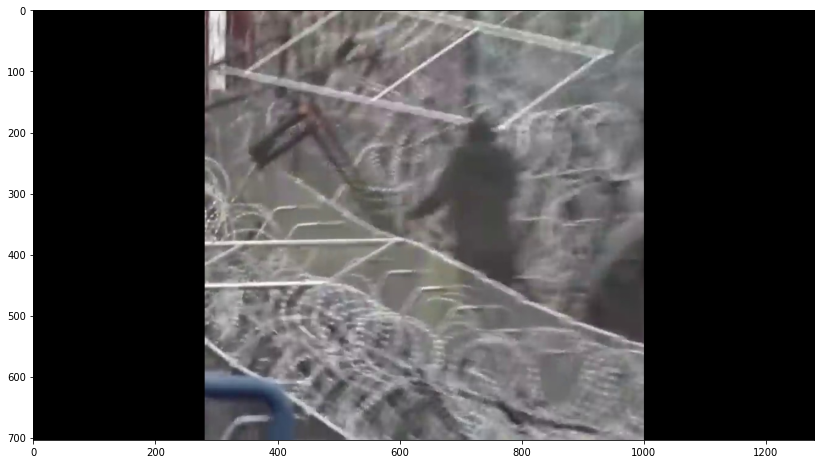

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


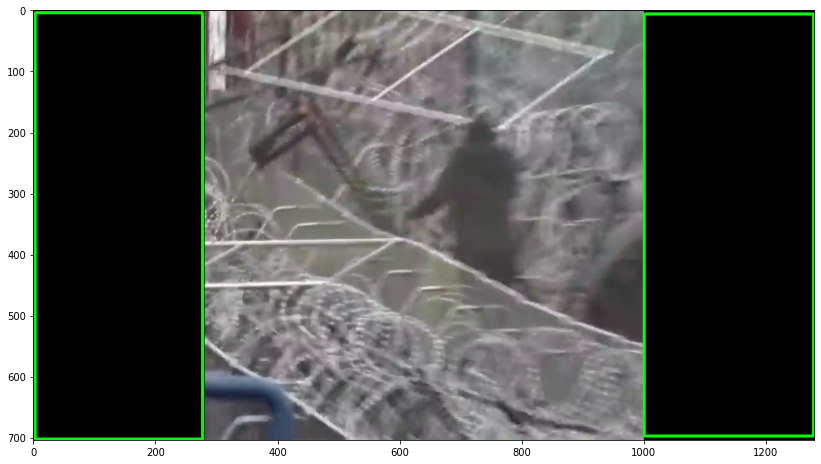

In [ ]:
# Получим список картинок в папке. На этих картинках будем проверять модель.
# Модель не видела этих картинок при обучении. Они были взяты из всех трех папок: 60img, 600img, 6000img

files = os.listdir(path_to_test)

# По всем картинкам из папки будем выводить сначала оригинальную картинку, потом её же, но у же с найденными черными рамками.
# Черные рамки будут обведены зелёным.

for file in files:
    
    # Отрисуем оригинальную картинку 
    fig, ax = plt.subplots(1, 1, figsize = (14, 14))
    test_image = cv2.imread(path_to_test+file)
    test_image = cv2.cvtColor(test_image , cv2.COLOR_BGR2RGB).astype(np.float32)
    test_image /= 255.0
    ax.imshow(test_image) 
    plt.show()

    result = BB_Detector(path_to_test+file)

    # Отрисуем картинку после прогона через модель
    fig, ax = plt.subplots(1, 1, figsize = (14, 14))
    ax.imshow(result) 
    plt.show()


In [ ]:
# Видно, что нейросеть справляется с задачей лучше чем поиск контуров.
# На картинке, где всё черное модель нашла не один, а три черных области.
# Это потому, что такие изображения отсутствовали в обучающей выборке.
# Уверен, что если докинуть черные изображения в трейн и обучать модель и на них, то она потом будет их обнаруживать.